The **Sturm-Liouville** eigenequation follows from a 2ODE of the form:

$$ p_0 y'' + p_1 y' + q_0 y = \lambda \rho y$$

for some unknown parameter $\lambda$. This is an eigenvalue problem if $p_0' = p_1$ and we can define the operator $\mathcal{L} = -(py')'+qy$, where a ' indicates a general derivative wrt x.

The everything here is a function of $x$. We can write each of these terms as:

- $p(x)$: coefficient function
- $q(x)$: potential function
- $\rho(x)$: weight function
- $\lambda$: eigenvalue
- $y(x)$: is therefore the solution of the 2ODE, and also the *eigenfunction*

Here we will solve numerically the Legendre Equation. Take the below on $\in[-1,1]$:

$$((1-x^2)y')' +\lambda y = 0$$

Clearly in this case $q=0$, $p=(1-x^2)$, $\rho = 1$.

The solutions are the Legendre polynomials $P_n(x)$ with the eigenvalues $\lambda_n = n(n+1) \;\; \forall n\in \mathbb{N}^{0+}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
#eigh_tridiagonal solves eigenvalue problems numerically

In [89]:
# Define domain and discretization
N = 100   # Number of interior grid points
x = np.linspace(-1, 1, N+2)  # Grid including boundaries
h = 2 / (N+1)  # Dynamically computed step size
x_interior = x[1:-1]  # Excluding boundary points

# Construct the finite difference matrix correctly
main_diag = (2 / h**2) * (1 - x_interior**2)  # Adjusted scaling
off_diag = (-1 / h**2) * (1 - x_interior[:-1]**2)  # Adjusted scaling

# Solve the eigenvalue problem for a tridiagonal matrix
eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

# Sort eigenvalues and eigenvectors properly
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

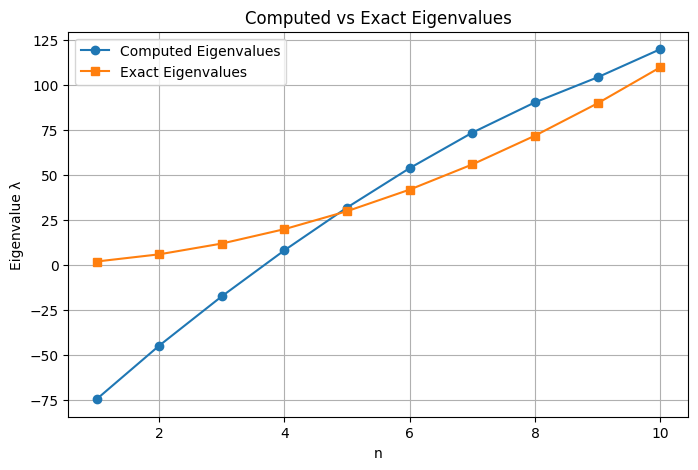

In [90]:
n_vals = np.arange(1, N+1)
lambda_exact = n_vals * (n_vals + 1)

# Plot eigenvalues to compare with exact values
plt.figure(figsize=(8, 5))
plt.plot(n_vals[:10], eigenvalues[:10], 'o-', label='Computed Eigenvalues')
plt.plot(n_vals[:10], lambda_exact[:10], 's-', label='Exact Eigenvalues')
plt.xlabel('n')
plt.ylabel('Eigenvalue λ')
plt.title('Computed vs Exact Eigenvalues')
plt.legend()
plt.grid()
plt.show()

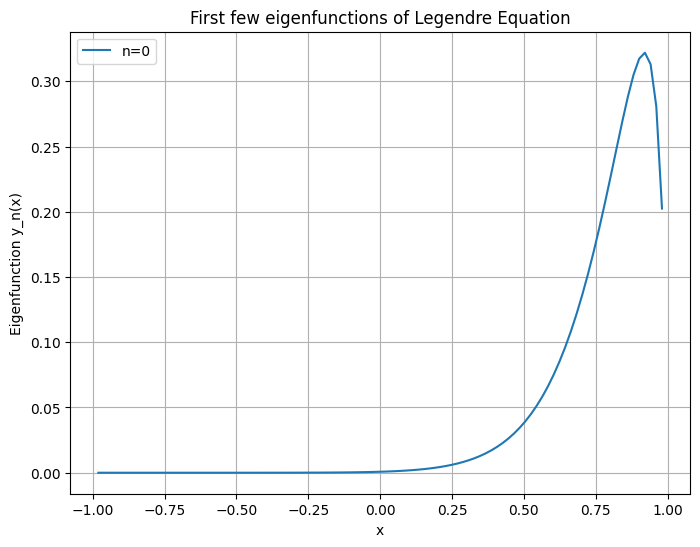

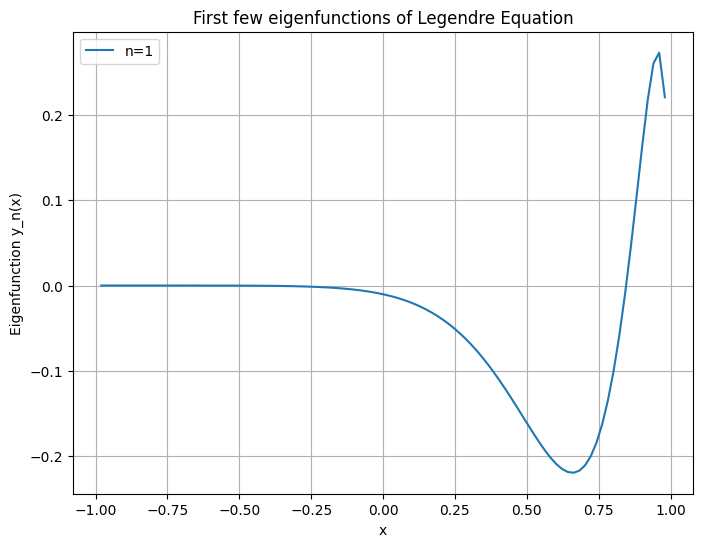

In [91]:
num_eigenfunctions = 2
for i in range(num_eigenfunctions):
    plt.figure(figsize=(8, 6))
    plt.plot(x_interior, eigenvectors[:, i], label=f'n={i}')
    plt.xlabel('x')
    plt.ylabel('Eigenfunction y_n(x)')
    plt.title('First few eigenfunctions of Legendre Equation')
    plt.legend()
    plt.grid()
    plt.show()

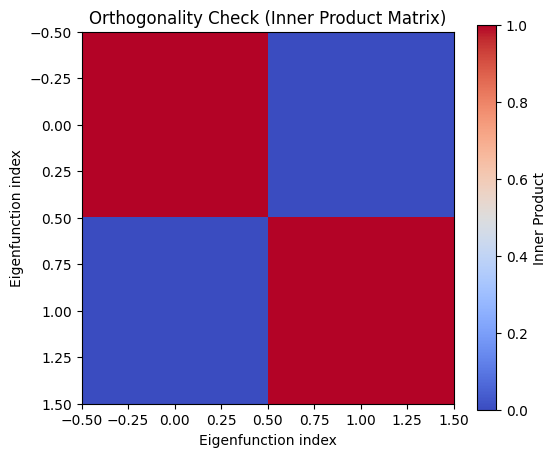

Inner product matrix (should be close to identity):
 [[1.00000000e+00 4.93196001e-17]
 [4.93196001e-17 1.00000000e+00]]


In [92]:
inner_products = np.dot(eigenvectors[:, :num_eigenfunctions].T, eigenvectors[:, :num_eigenfunctions])
plt.figure(figsize=(6, 5))
plt.imshow(inner_products, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Inner Product')
plt.title('Orthogonality Check (Inner Product Matrix)')
plt.xlabel('Eigenfunction index')
plt.ylabel('Eigenfunction index')
plt.show()

print("Inner product matrix (should be close to identity):\n", inner_products)